# 판교 AI Challenge
> 참치김치찌개팀<br>
> 팀장 손찬영, 팀원 김민정 김하림 이두현 차현수
* 과제명 : [아동 및 교통약자 보호를 위한 어린이 도로보행 위험행동 분류 과제]
* 과제 링크 : https://www.aiconnect.kr/main/competition/privateDetail/200

----------------------------------------------------------------

## Package

In [1]:
import glob
import math
import os
import random
import sys
import time
import timeit
import warnings

import easydict

warnings.filterwarnings("ignore")

# Others
from datetime import datetime

import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Customized Source Python Files
import source.dataset as dataset

# Pytorch
import torch
import wandb
from sklearn.metrics import f1_score
from source.ImbalancedDatasetSampler import ImbalancedDatasetSampler
from source.model import C3D_model, Efficientnet_LSTM, R2Plus1D_model, R3D_model
from source.model.utils.vit import TimeSformer
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

----------------------------------------------------------------

## Parameter Settings

In [2]:
args = easydict.EasyDict(
    {
        "experiment": "exp1 TimeSformer",  # 매번 바꿔준다.
        "wandb": False,
        "randomseed": False,
        "dataset": "kids",  # Options: hmdb51 or ucf101 or `kids`
        "dataset_root_dir": "./dataset",
        "project_dir": os.getcwd(),
        "pretrained_model": "./pretrained/TimeSformer_divST_96x4_224_K600.pyth",  # ./pretrained/c3d-pretrained.pth, ./pretrained/TimeSformer_divST_96x4_224_K600.pyth, 'efficientnet_b4'
        "snapshot": 20,  # Store a model every snapshot epochs
        "clip_len": 16, # 74 slice.
        "num_workers": 4,
        "model": "TimeSformer",  # Options: C3D, R2Plus1D, R3D, TimeSformer, Efficientnet_LSTM
        "attention_type": "divided_space_time",
        "num_frames": 75, # model
        "img_size": 224,
        "count": 20,  # how many repeat for wandb
        "epochs": 20,
        "learning_rate": 1e-3,
        "optimizer": "adam",
        "loss_function": "focal",
        "schedular": "cosineannealingwarmrestarts",
        "batch_size": 35,  # maximum is 35
        "multi_gpu": True,
        "autoaugment": 'imagenet', #'imagenet', # imagenet, svhn, cifar
    }
)
NAME_ELEMENTS = [args.model, time.strftime("%m%d_%H%M", time.localtime(time.time()))]
MODEL_NAME = "_".join(NAME_ELEMENTS)

----------------------------------------------------------------

## Randomseed & W and B

### 🚀 Setup

Start out by installing the experiment tracking library and setting up your free W&B account:<br>
`.login()` so you can log metrics to your projects<br>
If you've never used Weights & Biases before,
the call to `login` will give you a link to sign up for an account.
W&B is free to use for personal and academic projects!<br>
### 👈 Pick a `method`
The first thing we need to define is the `method`
for choosing new parameter values.

We provide the following search `methods`:
*   **`grid` Search** – Iterate over every combination of hyperparameter values.
Very effective, but can be computationally costly.
*   **`random` Search** – Select each new combination at random according to provided `distribution`s. Surprisingly effective!
*   **`bayesian` Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

We'll stick with `random`.

In [3]:
if args.randomseed:
    torch.manual_seed(args.randomseed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(args.randomseed)
    random.seed(args.randomseed)

In [4]:
if args.wandb:
    #%%wandb
    #%env WANDB_SILENT=True
    #%env "WANDB_NOTEBOOK_NAME" "main.ipynb"
    wandb.login()
    sweep_config = {
        "name": args.experiment,
        "method": "bayes",  # grid, bayesian, random
        "metric": {
            "name": "Weighted F1 Scrore",
            "goal": "maximize",
            # 'target': 'goal value for the metric you're optimizing, for example : 0.01'
        },
        "parameters": {
            "epochs": {"values": [10, 15, 20]},
            "learning_rate": {"distribution": "uniform", "min": 1e-4, "max": 1e-3,},
            "optimizer": {"values": ["adam", "sgd", "adamw", "adadelta", "nadam"]},
            "loss_function": {"values": ["focal", "cross_entropy", "label_smooth"]},
            "schedular": {
                "values": ["step", "onecycle", "cosineannealingwarmrestarts", "swa"]
            },
            "batch_size": {"values": [20, 35]},
        },
    }
    sweep_id = wandb.sweep(sweep_config, project="tunakimchi")
    os.environ["WANDB_NOTEBOOK_NAME"] = "main.ipynb"

----------------------------------------------------------------

## Model

In [5]:
# Use GPU if available else revert to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

if args.dataset == "hmdb51":
    num_classes = 51
elif args.dataset == "ucf101":
    num_classes = 101
elif args.dataset == "kids":
    num_classes = 9
else:
    print("We only implemented hmdb and ucf datasets.")
    raise NotImplementedError

saveName = args.model + "-" + args.dataset

Device being used: cuda


In [6]:
if args.model == "C3D":
    model = C3D_model.C3D(
        model_dir=args.pretrained_model, num_classes=num_classes, pretrained=True
    )

elif args.model == "R2Plus1D":
    model = R2Plus1D_model.R2Plus1DClassifier(
        num_classes=num_classes, layer_sizes=(2, 2, 2, 2)
    )
elif args.model == "R3D":
    model = R3D_model.R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))

elif args.model == "TimeSformer":
    model = TimeSformer(
        img_size=args.img_size,
        num_classes=num_classes,
        num_frames=args.num_frames,
        attention_type=args.attention_type,
        pretrained_model=args.pretrained_model,
    )

elif args.model == "Efficientnet_LSTM":
    model = Efficientnet_LSTM.net(pretrain_model=args.pretrained_model, embed_size=1280, LSTM_UNITS=64, DO=0.3)

else:
    raise NotImplementedError

In [7]:
print("Training {} from scratch...".format(args.model))
print("Total params: %.2fM" % (sum(p.numel() for p in model.parameters()) / 1000000.0))
if args.multi_gpu:
    model = nn.DataParallel(model)
model.to(device)
for i, c in enumerate(model.children()):
    if i == 0:
        for k, param in enumerate(c.parameters()):
            if k <= 245:
                param.requires_grad = False
            else:
                param.requires_grad = True
        print(k)

    print('#'*25)
    print(i)
    print(list(c.parameters()))
    print('#'*25)

Training TimeSformer from scratch...
Total params: 121.32M
248
#########################
0
[Parameter containing:
tensor([[[ 1.3503e-02,  2.3845e-02, -2.0858e-01,  8.7668e-03,  2.9668e-01,
           3.5680e-02, -3.3000e-02,  2.9659e-02,  2.1445e-02, -1.9272e-01,
          -2.3144e-02, -1.4303e-02,  2.6310e-03, -1.0293e-02, -2.3999e-02,
          -1.6945e-02,  2.9305e-03,  5.2897e-02,  4.0737e-02,  8.9609e-03,
          -5.5137e-02,  9.0171e-03,  4.5456e-03, -2.5922e-02,  1.0159e-02,
           4.9536e-02,  3.0321e-03,  5.2325e-03,  3.4678e-02, -2.6220e-02,
           2.5081e-04,  2.4663e-02, -3.2667e-02, -4.9615e-03,  8.9782e-03,
           3.9877e-03,  5.0979e-02, -8.0436e-03,  1.3856e-02, -1.1134e-02,
           2.4856e-02,  2.7569e-02,  6.2446e-03,  8.5140e-03,  2.9116e-02,
           3.5907e-01, -6.8465e-03, -9.8712e-03,  1.8814e-02, -1.6475e-02,
           5.2065e-03,  2.3289e-02, -1.5290e-02, -1.3400e-02,  1.1634e-03,
          -3.1316e-03, -1.3387e-02, -1.2994e-02,  1.2351e-02,

----------------------------------------------------------------

## Dataset Preprocessing and Loading

* 베이스라인 학습을 위한 데이터 경로 설정

원활한 베이스라인 학습을 위하여 `dataset` 디렉토리 안에 다음과 같이 경로를 설정하여 데이터를 저장해야한다.<br>
train 데이터셋은 카테고리별로 별도의 디렉토리에 비디오를 분리하여 저장해야 하는데, arrangement.ipynb를 이용하면 바로 분리하여 저장시켜준다.

```
dataset
├── label
│   └── kids_labels
├── train
│   ├── driveway_walk
│   │   ├── train_0003.mp4
│   │   └── ...
│   ├── fall_down
│   │   ├── train_0002.mp4
│   │   └── ...
│   └── fighting
│   │   ├── train_0056.mp4
│   │   └── ...
│   ...
└── test (공개가 안되어있다)
    ├── test_0000.mp4
    ├── test_0000.mp4
    ├── test_0000.mp4
    ├── ...
```

학습 및 추론 전처리 과정에서 각각 train_processed, test_processed 디렉토리가 다음과 같이 생성된다.<br>
이는 dataset.py를 실행시키면 되나, 굳이 할 필요는 없다.<br>
전처리에서는 비디오에서 16프레임을 샘플링한 이미지 데이터를 비디오 파일명 디렉토리에 별도로 저장하는 과정이 수행된다.
```
dataset
├── label
│   └── kids_labels
├── train
│   ├── driveway_walk
│   │   ├── train_0003.mp4
│   │   └── ...
│   ├── fall_down
│   │   ├── train_0002.mp4
│   │   └── ...
│   └── fighting
│   │   ├── train_0056.mp4
│   │   └── ...
│   ...
│
├── train_processed
│   ├── train
│   │   ├── driveway_walk
│   │   │   ├── train_0003
│   │   │   │   ├── 00000.jpg
│   │   │   │   ├── 00001.jpg
│   │   │   └── ...
│   │   └── ...
│   └── val
│   │   ├── driveway_walk
│   │   │   ├── train_0004
│   │   │   │   ├── 00000.jpg
│   │   │   │   ├── 00001.jpg
│   │   │   │   └── ...
│   │   │   └── ...
│   │   └── ...
│
├── test
│   ├── test_0000.mp4
│   ├── test_0000.mp4
│   ├── test_0000.mp4
│   └── ...
│
└── test_processed
    ├── test_0000
    │   ├── 00000.jpg
    │   ├── 00001.jpg
    │   └── ...
    ├── test_0001
    │   ├── 00000.jpg
    │   ├── 00001.jpg
    │   └── ...
    ├── ...
```

In [8]:
print("Training model on {} dataset...".format(dataset))
train_dataset = dataset.VideoDataset(
    root_dir=args.dataset_root_dir,
    dataset=args.dataset,
    split="train",
    clip_len=args.clip_len,
    autoaug=False,
)
val_dataset = dataset.VideoDataset(
    root_dir=args.dataset_root_dir,
    dataset=args.dataset,
    split="val",
    clip_len=args.clip_len,
    autoaug=False,
)


if args.autoaugment:
    print("AutoAugmentation by {} style".format(args.autoaugment))
    Dset = [
        dataset.VideoDataset(
            root_dir=args.dataset_root_dir,
            dataset=args.dataset,
            split="train",
            clip_len=args.clip_len,
            autoaug=args.autoaugment,
        )
    ]
    Dset.append(train_dataset)
    train_dataset = torch.utils.data.ConcatDataset(Dset)

print(
    "Total Train set samples:", len(train_dataset), "Val set samples:", len(val_dataset),
)


def build_dataset(batch_size):
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=args.num_workers,
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, num_workers=args.num_workers,
    )

    trainval_loaders = {"train": train_dataloader, "val": val_dataloader}
    trainval_sizes = {x: len(trainval_loaders[x].dataset) for x in ["train", "val"]}

    return trainval_loaders, trainval_sizes

Training model on <module 'source.dataset' from '/home/stephencha/Hub/soo/source/dataset.py'> dataset...
Number of train videos: 2663
Number of val videos: 670
AutoAugmentation by imagenet style
Number of train videos: 2663
Total Train set samples: 5326 Val set samples: 670


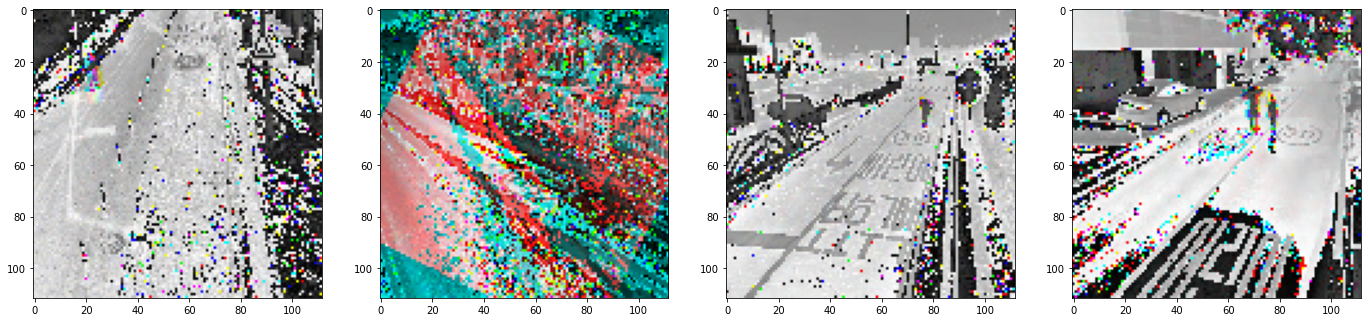

In [9]:
import torchvision.transforms as transforms

inverse_transform = transforms.Compose([transforms.ToPILImage()])

figure = plt.figure(figsize=(30, 30))

how_many_photos = 4
numbers = np.random.randint(1, len(train_dataset), size=how_many_photos)
for i, value in enumerate(numbers):
    sample = train_dataset[value][0]
    image = sample[2:3, 0:3, :, :]
    image = inverse_transform(image.squeeze())
    figure.add_subplot(1, 1 + how_many_photos, i + 1)
    imgplot = plt.imshow(image)
    if i == 3:
        plt.show()
        break

----------------------------------------------------------------

## Loss Function and Optimizer

In [10]:
import timm.optim.nadam as nadam
import torchcontrib
from source.focalloss import FocalLoss
from source.label_smooth import LabelSmoothSoftmaxCEV2
from torch.optim.swa_utils import SWALR
from torchcontrib.optim import SWA

In [11]:
def build_loss_function(lf):
    if lf == "focal":
        lf = FocalLoss()
    elif lf == "cross_entropy":
        lf = nn.CrossEntropyLoss()
    elif lf == "label_smooth":
        lf = LabelSmoothSoftmaxCEV2()
    return lf

In [12]:
def build_optimizer(model, opt, lr):
    if args.model == "C3D":
        param = [
            {"params": C3D_model.get_1x_lr_params(model), "lr": lr},
            {"params": C3D_model.get_10x_lr_params(model), "lr": lr * 10},
        ]
    elif args.model == "R2Plus1D":
        param = [
            {"params": R2Plus1D_model.get_1x_lr_params(model), "lr": lr},
            {"params": R2Plus1D_model.get_10x_lr_params(model), "lr": lr * 10},
        ]
    elif args.model == "R3D":
        param = model.parameters()
    elif args.model == "TimeSformer":
        param = model.parameters()
    elif args.model == "Efficientnet_LSTM":
        param = model.parameters()
    else:
        raise NotImplementedError

    if opt == "sgd":
        optimizer = optim.SGD(param, lr=lr, momentum=0.9, weight_decay=5e-4)
    elif opt == "adam":
        optimizer = optim.Adam(param, lr=lr, amsgrad=True)
    elif opt == "adamw":
        optimizer = optim.AdamW(param, lr=lr)
    elif opt == "adadelta":
        optimizer = optim.Adadelta(param, lr=lr)
    elif opt == "nadam":
        optimizer = nadam.Nadam(param, lr=lr)
    return optimizer

In [13]:
def build_schedular(optimizer, sche, epochs, length):
    if sche == "step":
        schedular = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif sche == "onecycle":
        schedular = optim.lr_scheduler.OneCycleLR(
            optimizer,
            pct_start=0.1,
            div_factor=1e5,
            max_lr=0.0001,
            epochs=epochs,
            steps_per_epoch=length,
        )
    elif sche == "cosineannealingwarmrestarts":
        schedular = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5, last_epoch=-1
        )
    elif sche == "swa":
        schedular = SWALR(optimizer, swa_lr=0.01)
    return schedular

----------------------------------------------------------------

## Train
* epoch마다 학습과 검증을 실시한다.
* `./run/run_*` 디렉토리에서 저장된 가중치 파일을 확인한다.

In [14]:
# build run dir
runs = sorted(glob.glob(os.path.join(args.project_dir, "run", "run_*")))
order = []
for r in runs:
    order.append(int(r.split("_")[-1]))
order.sort()
run_id = order[-1] if runs else 0
print("run id: ", run_id)
SAVE_DIR = os.path.join(args.project_dir, "run", "run_" + str(run_id).zfill(3))
model_save_dir = os.path.join(SAVE_DIR, "models")

print("save directory: ", model_save_dir)

run id:  0
save directory:  /home/stephencha/Hub/soo/run/run_000/models


In [15]:
def train():
    if args.wandb:
        with wandb.init(config=args, name=MODEL_NAME) as run:  # reinit=True
            config = wandb.config
    else:
        config = args

    trainval_loaders, trainval_sizes = build_dataset(config.batch_size)

    # standard crossentropy loss for classification
    criterion = build_loss_function(config.loss_function)
    optimizer = build_optimizer(model, opt=config.optimizer, lr=config.learning_rate)

    # the scheduler divides the lr by 10 every 10 epochs
    if config.schedular == "swa":
        optimizer = torchcontrib.optim.SWA(optimizer)

    scheduler = build_schedular(
        optimizer,
        sche=config.schedular,
        epochs=config.epochs,
        length=len(trainval_loaders["train"]),
    )

    best_score = 0  # np.Inf
    for epoch in range(config.epochs):
        # each epoch has a training and validation step
        for phase in ["train", "val"]:
            start_time = timeit.default_timer()

            # reset the running loss and corrects
            running_loss = 0.0
            running_corrects = 0.0

            # set model to train() or eval() mode depending on whether it is trained
            # or being validated. Primarily affects layers such as BatchNorm or Dropout.
            if phase == "train":
                # scheduler.step() is to be called once every epoch during training
                scheduler.step()
                model.train()
            else:
                model.eval()

            epoch_labels = []
            epoch_preds = []

            for inputs, labels in tqdm(trainval_loaders[phase]):
                # move inputs and labels to the device the training is taking place on
                inputs = Variable(inputs, requires_grad=True).to(device)
                labels = Variable(labels).to(device)
                optimizer.zero_grad()

                if phase == "train":
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)

                probs = nn.Softmax(dim=1)(outputs)
                preds = torch.max(probs, 1)[1]
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                epoch_labels.extend(labels.tolist())
                epoch_preds.extend(preds.tolist())

            epoch_loss = running_loss / trainval_sizes[phase]
            epoch_acc = running_corrects.double() / trainval_sizes[phase]

            epoch_score = f1_score(epoch_preds, epoch_labels, average="weighted")
            print(f"{phase} | EPOCH {epoch} Weighted F1 SCORE: {epoch_score}")

            print(
                "[{}] Epoch: {}/{} Loss: {} Acc: {}".format(
                    phase, epoch + 1, config.epochs, epoch_loss, epoch_acc
                )
            )
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

            if args.wandb and phase == "val":
                wandb.log(
                    {"Weighted F1 Scrore": epoch_score,}
                )

            if epoch_score > best_score and phase == "val":
                print(
                    f"Validation Weighted F1 Score increased ({best_score:.6f} --> {epoch_score:.6f}).  Saving model ..."
                )
                model_path = os.path.join(
                    #SAVE_DIR,
                    #"models",
                    model_save_dir,
                    saveName
                    + "_epoch-"
                    + str(epoch).zfill(3)
                    + "_epoch_score-{:.6f}.pt".format(epoch_score)
                    + ".pth.tar",
                )
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "state_dict": model.state_dict(),
                        "opt_dict": optimizer.state_dict(),
                    },
                    model_path,
                )
                print("Save model at {}\n".format(model_path))
                best_score = epoch_score

----------------------------------------------------------------

## Inference
* 루트 디렉토리에 생성된 `submit.csv` 파일을 확인하고, 제출합니다.

In [16]:
cls_li = [
    "driveway_walk",
    "fall_down",
    "fighting",
    "jay_walk",
    "normal",
    "putup_umbrella",
    "ride_cycle",
    "ride_kick",
    "ride_moto",
]

DATA_DIR = args.dataset_root_dir  # os.path.join(PROJECT_DIR, '')
batch_size = 4

In [20]:
runs_pt = os.listdir(model_save_dir)
runs_pt.sort()
model_path = model_save_dir + "/" + runs_pt[-1]  # Latest
checkpoint = torch.load(model_path)
print(f"Initializing weights from: {model_path.split('/')[-1]}...")
model.load_state_dict(checkpoint["state_dict"])
print("Total params: %.2fM" % (sum(p.numel() for p in model.parameters()) / 1000000.0))

print("Model Inference on {} dataset...".format(dataset))

if os.path.isdir(os.path.join(DATA_DIR, "test_processed")):
    preprocess = False
else:
    preprocess = True

test_dataset = dataset.TestDataset(
    root_dir=args.dataset_root_dir,
    dataset=dataset,
    clip_len=16,
    preprocess=preprocess
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

model.eval()
start_time = timeit.default_timer()

pred_li = []
for inputs in tqdm(test_dataloader):
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    probs = nn.Softmax(dim=1)(outputs)
    preds = torch.max(probs, 1)[1]
    pred_li.extend(preds.tolist())

stop_time = timeit.default_timer()
print("Execution time: " + str(stop_time - start_time) + "\n")

  0%|          | 0/192 [00:00<?, ?it/s]

Initializing weights from: TimeSformer-kids_epoch-006_epoch_score-0.710884.pt.pth.tar...
Total params: 121.32M
Model Inference on <module 'source.dataset' from '/home/stephencha/Hub/soo/source/dataset.py'> dataset...
Number of test set videos: 768


100%|██████████| 192/192 [01:02<00:00,  3.07it/s]

Execution time: 62.52653601201018



----------------------------------------------------------------

## Submission

In [21]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["class"] = [cls_li[int(pred)] for pred in pred_li]
sample_submission.to_csv("submit_{}.csv".format(model_path.split('/')[-1]), index=False)

----------------------------------------------------------------